In [25]:
import sys
import time

# Maths things
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Algorithm
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from metric_learn import MLKR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import SelectFromModel

from functools import partial
from sklearn import preprocessing

In [26]:
data = np.load('regression_data.npy')
target = np.loadtxt('target_values.txt')

In [27]:
error = mean_absolute_error

In [28]:
X_ltrain, X_test, Y_ltrain, Y_test = train_test_split(data, target, test_size = 100, random_state = 7)

In [29]:
from sklearn import preprocessing
X_ltrain = preprocessing.normalize(X_ltrain);
X_test =  preprocessing.normalize(X_test);

In [30]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_ltrain, Y_ltrain, test_size = 100, random_state = 17)

In [31]:
X_train.shape

(554, 27827)

## Importance Selection and Metric

In [32]:
selector = SelectFromModel(estimator=LinearRegression(),threshold="1.25*mean").fit(X_train, Y_train)
selector.estimator_.coef_

selector.threshold_
selector.get_support()

selector.transform(X_train);
X_train_redu, X_test_redu = (selector.transform(X_train),selector.transform(X_valid))

*Linear regression with original data


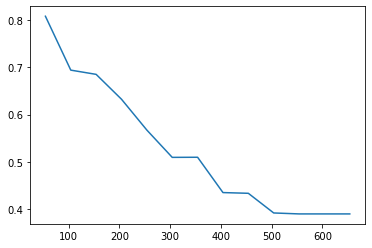

CPU times: user 14.6 s, sys: 216 ms, total: 14.8 s
Wall time: 3.7 s


In [33]:
%%time
numbers_train = np.arange(54,655,50)
losses_lr = np.zeros((len(numbers_train)))
for i,n in enumerate(numbers_train):
    Xt_train = X_train[:n]
    Yt_train = Y_train[:n]
    lr = LinearRegression()
    lr.fit(Xt_train,Yt_train)
    Y_pred = lr.predict(X_valid)
    loss = error(Y_valid, Y_pred)
    losses_lr[i] = loss
    #print(i)
print('*Linear regression with original data')

plt.plot(numbers_train,losses_lr)
plt.show()

In [34]:
X_ltrain = selector.transform(X_ltrain)
X_train  = selector.transform(X_train)
X_valid  = selector.transform(X_valid)
X_test   = selector.transform(X_test)

In [35]:
X_ltrain.shape

(654, 5676)

# Feature Selection

## MLKR

In [88]:
np.logspace(0.3,3,20).astype(int)

array([   1,    2,    3,    5,    7,   10,   14,   19,   27,   37,   52,
         72,  101,  140,  194,  270,  374,  519,  720, 1000])

### Optimization of the number of PC

In [89]:
%%time
numbers_pc = np.logspace(0.3,3,20).astype(int)#np.arange(1,40,5)
losses_mlkr_n_pc = np.zeros((len(numbers_pc)))
for i,n_pc in enumerate(numbers_pc):
    mlkr = MLKR(n_components=n_pc)
    mlkr.fit(X = X_train, y = Y_train)
    T_train = mlkr.transform(X_train)
    T_valid= mlkr.transform(X_valid)
    lr = LinearRegression()
    lr.fit(T_train, Y_train)
    Y_pred = lr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_mlkr_n_pc[i] = loss
    print(n_pc)

1
2
3
5
7
10
14
19
27
37
52
72
101
140
194
270
374
519
720
1000
CPU times: user 3h 12min 39s, sys: 2min 25s, total: 3h 15min 4s
Wall time: 55min 7s


In [90]:
optimal_index_n_pc_mlkr = np.unravel_index(losses_mlkr_n_pc.argmin(), losses_mlkr_n_pc.shape)
optimal_n_pc_mlkr = numbers_pc[optimal_index_n_pc_mlkr]
print("Optimal number of n_pc for MLKR using LR is {} ".format(optimal_n_pc_mlkr))

Optimal number of n_pc for MLKR using LR is 270 


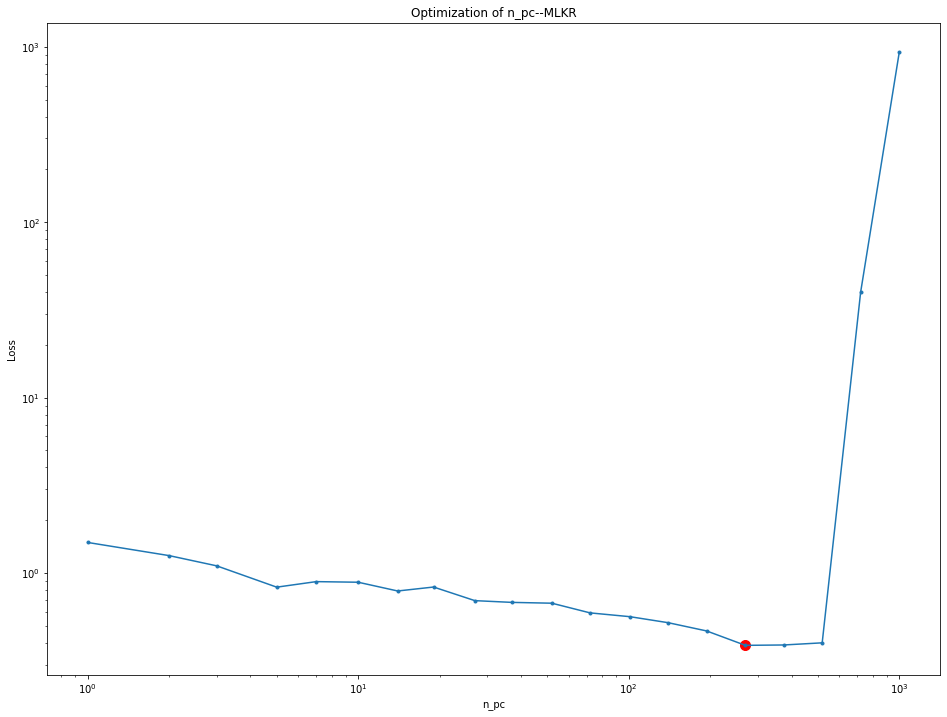

In [92]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_pc,losses_mlkr_n_pc,'.-')
plt.scatter(optimal_n_pc_mlkr, losses_mlkr_n_pc[optimal_index_n_pc_mlkr], s = 100,marker='o', color='r')
plt.xlabel('n_pc')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Optimization of n_pc--'+'MLKR')
plt.show()

# Retrain and Datat Processing

In [119]:
optimal_n_pc_mlkr =2

In [120]:
best_mlkr = MLKR(n_components=optimal_n_pc_mlkr)
best_mlkr.fit(X = X_ltrain, y = Y_ltrain)
T_ltrain = best_mlkr.transform(X_ltrain)
T_train  = best_mlkr.transform(X_train)
T_valid  = best_mlkr.transform(X_valid)
T_test   = best_mlkr.transform(X_test)

In [134]:
T_ltrain[:,1].shape

(654,)

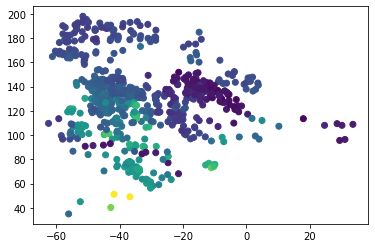

In [140]:
plt.scatter(T_ltrain[:,0],T_ltrain[:,1],c=Y_ltrain.T)

# Try different regression models

## Linear Regression

### No need for optimization

### Learning Curve

In [95]:
lr = LinearRegression()
numbers_train = np.arange(54,655,50)
losses_lr = np.zeros((len(numbers_train)))

In [96]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    lr.fit(Tt_train,Yt_train)
    Y_pred = lr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_lr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 438 ms, sys: 7.98 ms, total: 446 ms
Wall time: 111 ms


In [97]:
optimal_index_loss_lr = np.unravel_index(losses_lr.argmin(), losses_lr.shape)
optimal_n_train_lr = numbers_train[optimal_index_loss_lr]
min_loss_lr = losses_lr[optimal_index_loss_lr]
print("Minimum loss of LR with MLKR is {} when number of train is {}  ".format(min_loss_lr,optimal_n_train_lr))

Minimum loss of LR with MLKR is 0.5087660474972348 when number of train is 654  


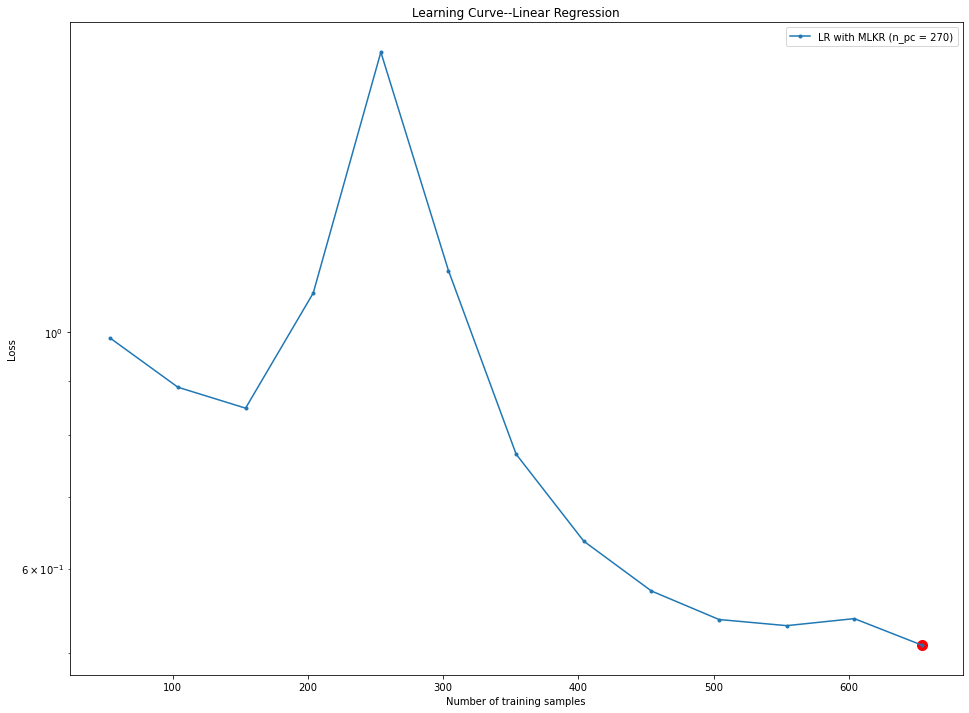

In [98]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_lr,'.-', label='LR with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_lr, min_loss_lr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Linear Regression')
plt.show()

## Ridge Regression

### Optimization

#### Optimization of alpha

In [99]:
%%time
alphas =  np.logspace(-10, 4, 29)
losses_rr_alpha = np.zeros((len(alphas)))
for i,alpha in enumerate(alphas):
    rr = Ridge(alpha = alpha)
    rr.fit(T_train, Y_train)
    Y_pred = rr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_rr_alpha[i] = loss
    print(alpha)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
31.622776601683793
100.0
316.22776601683796
1000.0
3162.2776601683795
10000.0
CPU times: user 298 ms, sys: 7.93 ms, total: 306 ms
Wall time: 76.2 ms


In [100]:
optimal_index_alpha_rr = np.unravel_index(losses_rr_alpha.argmin(), losses_rr_alpha.shape)
optimal_alpha_rr = alphas[optimal_index_alpha_rr]
print("Optimal alpha for RR with MLKR is {} ".format(optimal_alpha_rr))

Optimal alpha for RR with MLKR is 0.0001 


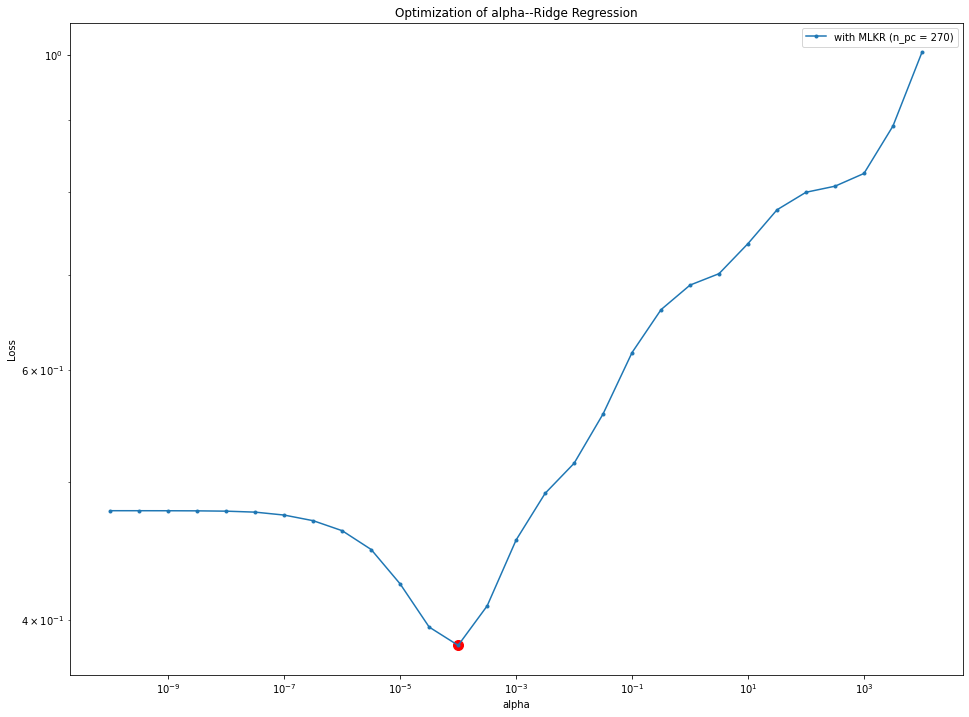

In [101]:
plt.figure(figsize=(16, 12))
plt.plot(alphas,losses_rr_alpha,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_alpha_rr, losses_rr_alpha[optimal_index_alpha_rr], s = 100,marker='o', color='r')
plt.xlabel('alpha')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization of alpha--'+'Ridge Regression')
plt.show()

### Learning Curve

In [102]:
best_rr = Ridge(alpha = optimal_alpha_rr)
numbers_train = np.arange(54,655,50)
losses_rr = np.zeros((len(numbers_train)))

In [103]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    best_rr.fit(Tt_train,Yt_train)
    Y_pred = best_rr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_rr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 88.1 ms, sys: 49 µs, total: 88.1 ms
Wall time: 22.5 ms


In [104]:
losses_rr

array([0.94505674, 0.80657869, 0.6818399 , 0.70045568, 0.62829564,
       0.59269011, 0.59596744, 0.6028015 , 0.56137948, 0.53425622,
       0.52329901, 0.53344398, 0.50883856])

In [105]:
optimal_index_loss_rr = np.unravel_index(losses_rr.argmin(), losses_rr.shape)
optimal_n_train_rr = numbers_train[optimal_index_loss_rr]
min_loss_rr = losses_rr[optimal_index_loss_rr]
print("Minimum loss of RR with MLKR is {} when number of train is {}  ".format(min_loss_rr,optimal_n_train_rr))

Minimum loss of RR with MLKR is 0.5088385610159828 when number of train is 654  


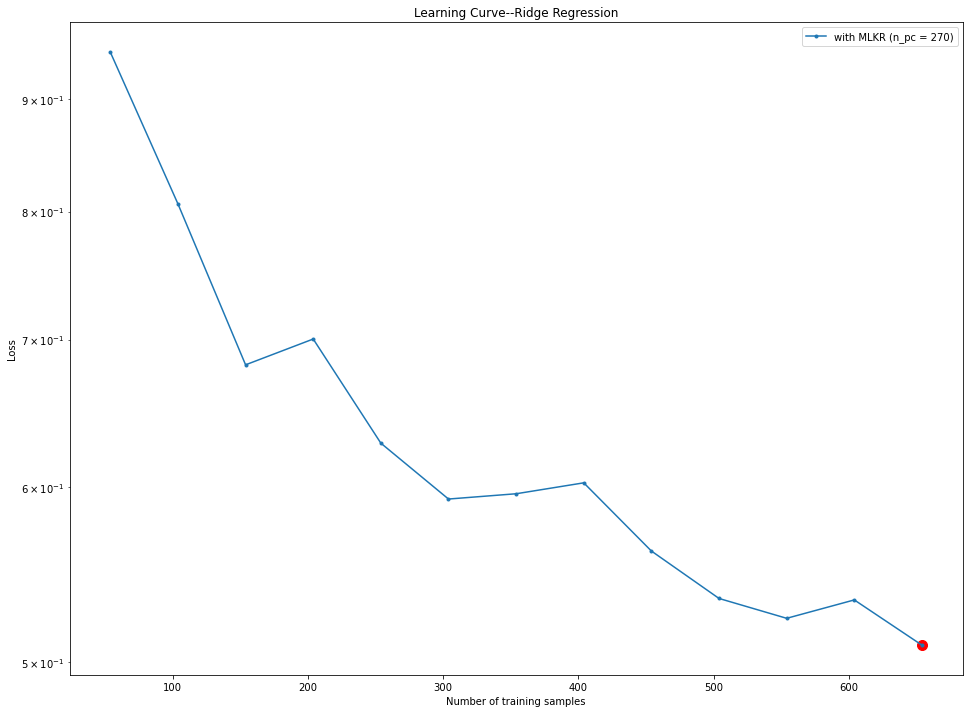

In [106]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_rr,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_rr, min_loss_rr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Ridge Regression')
plt.show()

## Kernel Ridge Regression

### Optimization

#### Optimization of gamma

In [107]:
%%time
gammas =  np.logspace(-10, 1, 23)
losses_krr_gamma = np.zeros((len(gammas)))
kernel_params = {"kernel": "rbf", "gamma": 1.0}
for i,gamma in enumerate(gammas):
    kernel_params["gamma"] = gamma
    krr = KernelRidge(alpha = 1e-6, **kernel_params)
    krr.fit(T_train, Y_train)
    Y_pred = krr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_krr_gamma[i] = loss
    print(gamma)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
CPU times: user 897 ms, sys: 12.2 ms, total: 909 ms
Wall time: 227 ms


In [108]:
optimal_index_gamma_krr = np.unravel_index(losses_krr_gamma.argmin(), losses_krr_gamma.shape)
optimal_gamma_krr = gammas[optimal_index_gamma_krr]
print("Optimal gamma for KRR with MLKR is {} ".format(optimal_gamma_krr))

Optimal gamma for KRR with MLKR is 0.0031622776601683794 


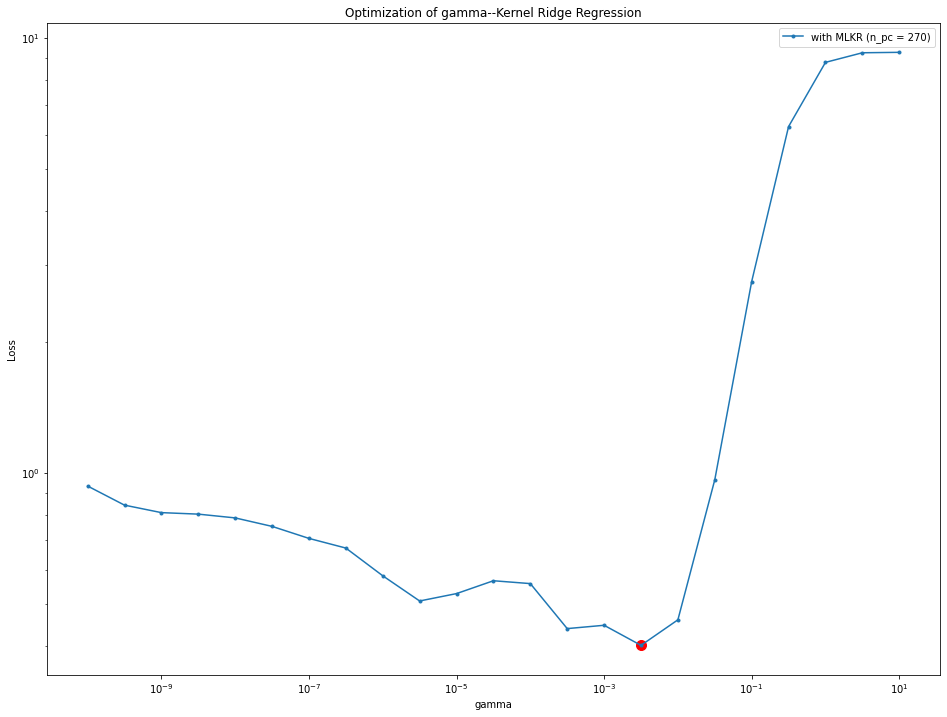

In [109]:
plt.figure(figsize=(16, 12))
plt.plot(gammas,losses_krr_gamma,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_gamma_krr, losses_krr_gamma[optimal_index_gamma_krr], s = 100,marker='o', color='r')
plt.xlabel('gamma')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization of gamma--'+'Kernel Ridge Regression')
plt.show()

#### Optimization of alpha

In [110]:
%%time
alphas =  np.logspace(-10, 1, 23)
losses_krr_alpha = np.zeros((len(alphas)))
kernel_params = {"kernel": "rbf", "gamma": optimal_gamma_krr}
for i,alpha in enumerate(alphas):
    krr = KernelRidge(alpha = alpha, **kernel_params)
    krr.fit(T_train, Y_train)
    Y_pred = krr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_krr_alpha[i] = loss
    print(alpha)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
CPU times: user 776 ms, sys: 11.9 ms, total: 788 ms
Wall time: 197 ms


In [111]:
optimal_index_alpha_krr = np.unravel_index(losses_krr_alpha.argmin(), losses_krr_alpha.shape)
optimal_alpha_krr = alphas[optimal_index_alpha_krr]
print("Optimal alpha for KRR with MLKR is {} ".format(optimal_alpha_krr))

Optimal alpha for KRR with MLKR is 3.1622776601683795e-05 


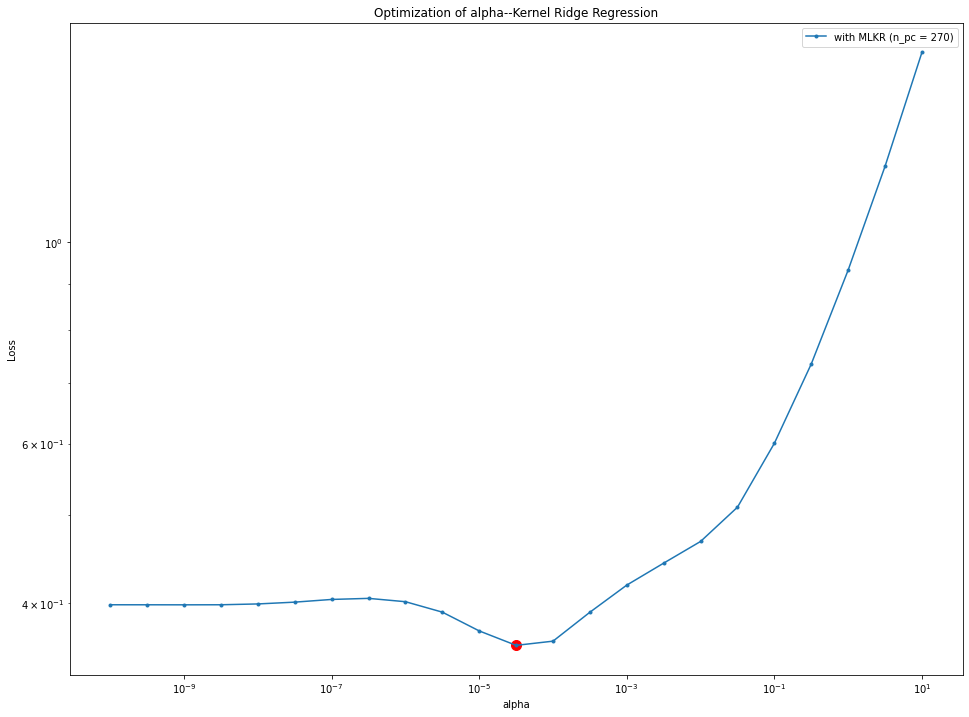

In [112]:
plt.figure(figsize=(16, 12))
plt.plot(alphas,losses_krr_alpha,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_alpha_krr, losses_krr_alpha[optimal_index_alpha_krr], s = 100,marker='o', color='r')
plt.xlabel('alpha')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization of alpha--'+'Kernel Ridge Regression')
plt.show()

### Learning Curve

In [113]:
best_krr = KernelRidge(alpha = optimal_alpha_krr, **kernel_params)
numbers_train = np.arange(54,655,50)
losses_krr = np.zeros((len(numbers_train)))

In [114]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    best_krr.fit(Tt_train,Yt_train)
    Y_pred = best_krr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_krr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 335 ms, sys: 3.88 ms, total: 339 ms
Wall time: 85.1 ms


In [115]:
losses_krr

array([1.2081306 , 0.8433987 , 0.87758539, 0.77972314, 0.72272397,
       0.51995439, 0.47922413, 0.50374331, 0.47201476, 0.46700056,
       0.46599103, 0.45639247, 0.41279063])

In [116]:
optimal_index_loss_krr = np.unravel_index(losses_krr.argmin(), losses_krr.shape)
optimal_n_train_krr = numbers_train[optimal_index_loss_krr]
min_loss_krr = losses_krr[optimal_index_loss_krr]
print("Minimum loss of KRR with MLKR is {} when number of train is {}  ".format(min_loss_krr,optimal_n_train_krr))

Minimum loss of KRR with MLKR is 0.41279062680055434 when number of train is 654  


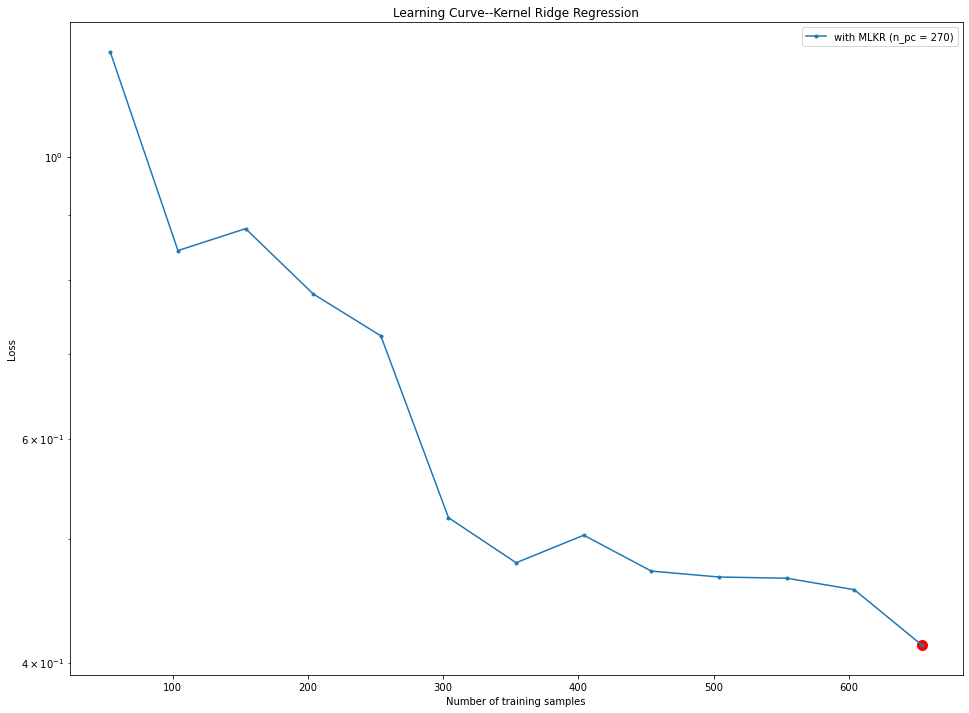

In [117]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_krr,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_krr, min_loss_krr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Kernel Ridge Regression')
plt.show()

### Summary

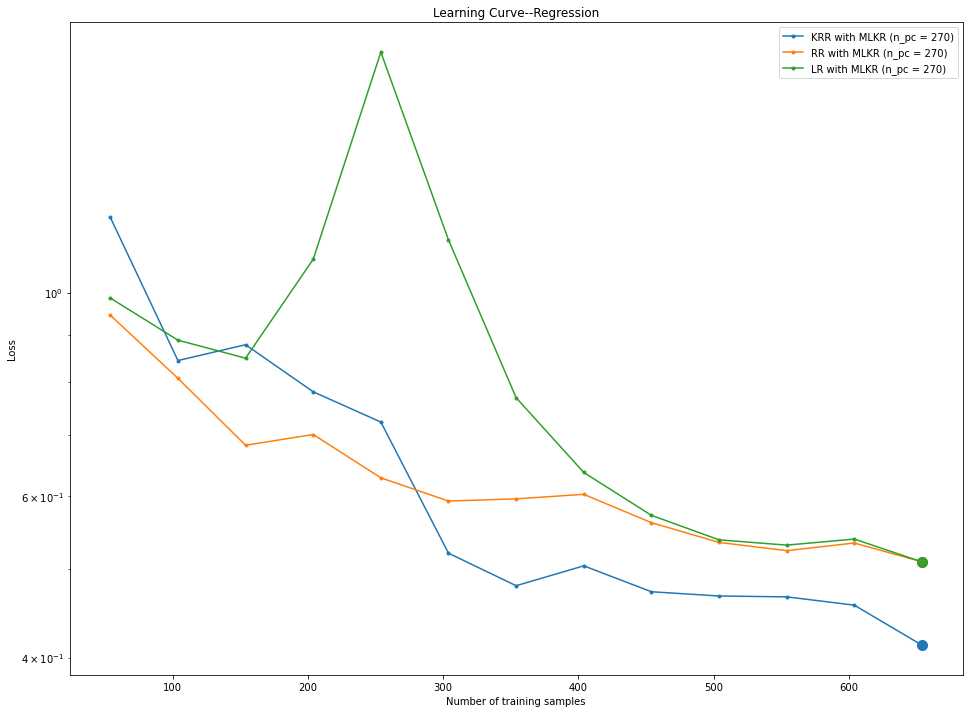

In [118]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_krr,'.-', label='KRR with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_krr, min_loss_krr, s = 100,marker='o')
plt.plot(numbers_train,losses_rr,'.-', label='RR with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_rr, min_loss_rr, s = 100,marker='o')
plt.plot(numbers_train,losses_lr,'.-', label='LR with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_lr, min_loss_lr, s = 100,marker='o')

plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Regression')
plt.show()